The game plan:
1. Label transition errors using time-average thresholding
2. See how early we can classify these errors with a neural network

In [1]:
import os 

# Create saving directory, save config file to that directory

transition_errors_dir = os.path.join(os.getcwd(), "transition_errors")
os.makedirs(transition_errors_dir, exist_ok=True)
dirs_used = [i for i in os.listdir(transition_errors_dir) if os.path.isdir(os.path.join(transition_errors_dir, i))]
dirs_used = [i for i in dirs_used if i != "test"]
nums_used = [int(i) for i in dirs_used]

if len(dirs_used)==0:
    SAVE_DIR_NUM = 0
else:
    SAVE_DIR_NUM = max(nums_used) + 1
SAVE_DIR = os.path.join(transition_errors_dir, str(SAVE_DIR_NUM))
os.makedirs(SAVE_DIR, exist_ok = False)
print(f"SAVE_DIR: {SAVE_DIR}")


SAVE_DIR: /data/aelabd/ml-quantum-readout/notebooks/transition_errors/66


In [2]:
# SAVE_DIR = SAVE_DIR.replace(str(SAVE_DIR_NUM), "test")
# os.makedirs(SAVE_DIR, exist_ok = True)

In [3]:
import time
import sys 
sys.path.append("../training")
import pickle
import copy
from itertools import combinations, permutations
import timeit
import yaml

import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Softmax, ReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

##################### Local imports ################################
from save_data import process_data
from threshold import ThresholdModel

#################### Helper functions #############################
# One-hot-encodes data for neural network
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],4], dtype=np.int32)
    for idx, x in enumerate(data):
        y_encoded[idx,int(x)] = 1
    return y_encoded

################## Global variables ################################
# Not all global variables are defined here, some necessarily defined below
VALIDATION_SPLIT = 0.3
NP_SEED = 0
np.random.seed(NP_SEED)

START_WINDOW = 0
END_WINDOW = 770
DATA_DIR = "../data/data_0_resplit"

TRANSITION_WINDOW_START = 0
TRANSITION_WINDOW_END = 500

INIT_LEARNING_RATE = 1e-2
BATCH_SIZE = 12800
EPOCHS = 50

# Config file: Has all the data about our global variables and stuff we want to save
GLOBAL_CONFIG = {
    "VALIDATION_SPLIT": VALIDATION_SPLIT,
    "NP_SEED": NP_SEED,
    "START_WINDOW": START_WINDOW,
    "END_WINDOW": END_WINDOW,
    "DATA_DIR": DATA_DIR,
    "TRANSITION_WINDOW_START": TRANSITION_WINDOW_START,
    "TRANSITION_WINDOW_END": TRANSITION_WINDOW_END,
    "INIT_LEARNING_RATE": INIT_LEARNING_RATE,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS
}

2024-05-31 18:10:31.166339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 18:10:31.295623: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-31 18:10:31.295647: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-31 18:10:31.875652: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Create a directory to which we will save all results

## 1. Data

In [4]:
# convert raw ADC data into npy files 
if os.path.exists(f"{DATA_DIR}/X_train.npy") == False:
    process_data(
        start_window=START_WINDOW,
        end_window=END_WINDOW, 
        data_dir=DATA_DIR
    )

# load data
X_tv = np.load(os.path.join(DATA_DIR, 'X_train.npy'))
y_tv = np.load(os.path.join(DATA_DIR, 'y_train.npy'))
X_test = np.load(os.path.join(DATA_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(DATA_DIR, 'y_test.npy'))

# Check that it's the correct size
# X_train_val[0] = I, Q timeseries over (END_WINDOW - START_WINDOW) timesteps
assert X_tv.shape[1] == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"
assert X_test.shape[1] == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"

# Shuffle train-val indeces
tv_shuffler = np.random.permutation(range(X_tv.shape[0]))
X_tv = X_tv[tv_shuffler, :]
y_tv = y_tv[tv_shuffler]

# Train-validate split
X_train = X_tv[:int((1-VALIDATION_SPLIT)*X_tv.shape[0]),:]
y_train = y_tv[:int((1-VALIDATION_SPLIT)*y_tv.shape[0])]
X_val = X_tv[int((1-VALIDATION_SPLIT)*X_tv.shape[0]):, :]
y_val = y_tv[int((1-VALIDATION_SPLIT)*X_tv.shape[0]):]

## 2. Label transition errors using time-average thresholding

Interpretation:
- True positives = qubit is actually in |1>
- True negatives = qubit is actually in |0>
- False positives = excitation error
- False negatives = relaxation error

Obviously, some of these false-positives/false-negatives might be state-preparation errors or the threshold model being wrong. 

In [5]:
def label_transition_errors(y_true, y_pred):
    assert(y_true.shape==y_pred.shape)
    
    y_new = np.zeros(y_true.shape)
    idx_true_pos = np.where((y_true==1)&(y_pred==1))[0]
    idx_true_neg = np.where((y_true==0)&(y_pred==0))[0]
    idx_false_pos = np.where((y_true==0)&(y_pred==1))[0]
    idx_false_neg = np.where((y_true==1)&(y_pred==0))[0]

    #y_new[idx_true_neg] = 0
    y_new[idx_true_pos] = 1
    y_new[idx_false_neg] = 2 # relaxation error
    y_new[idx_false_pos] = 3 # excitation error
    return y_new

# Fit threshold model to training data
thresh_mod = ThresholdModel()
thresh_mod.fit(X_train, y_train)

# This might be bad practice, but we're going to shift+tilt the threshold-discriminator a bit  to account for the threshold model being biased due to 
# the existence of transition errors in the training data
# I believe this is justified because we're using the threshold-model to label these transition errors in the first place
# We can also fit this shift+tilt to the validation set (instead of the test set), so we can call it hyperparameter tuning
# Machine learning << eyeballing it
THETA_MUL = 0.94
THRESH_MUL = 1.2 #1.25 #1.14
thresh_mod.theta *= THETA_MUL
thresh_mod.threshold *= THRESH_MUL
# Relabel training data with transition errors 
y_train_threshpred = thresh_mod.predict(X_train)
y_train_prime = label_transition_errors(y_train, y_train_threshpred)

# Relabel validation data with transition errors
y_val_threshpred = thresh_mod.predict(X_val)
y_val_prime = label_transition_errors(y_val, y_val_threshpred)

# Relabel test data with transition errors
y_test_threshpred = thresh_mod.predict(X_test)
y_test_prime = label_transition_errors(y_test, y_test_threshpred)

# Check class proportions
print(f"sum(y_train_prime==0) = {sum(y_train_prime==0)}")
print(f"sum(y_train_prime==1) = {sum(y_train_prime==1)}")
print(f"sum(y_train_prime==2) = {sum(y_train_prime==2)}")
print(f"sum(y_train_prime==3) = {sum(y_train_prime==3)}")

print(f"\nsum(y_val_prime==0) = {sum(y_val_prime==0)}")
print(f"sum(y_val_prime==1) = {sum(y_val_prime==1)}")
print(f"sum(y_val_prime==2) = {sum(y_val_prime==2)}")
print(f"sum(y_val_prime==3) = {sum(y_val_prime==3)}")

print(f"\nsum(y_test_prime==0) = {sum(y_test_prime==0)}")
print(f"sum(y_test_prime==1) = {sum(y_test_prime==1)}")
print(f"sum(y_test_prime==2) = {sum(y_test_prime==2)}")
print(f"sum(y_test_prime==3) = {sum(y_test_prime==3)}")


sum(y_train_prime==0) = 312804
sum(y_train_prime==1) = 295655
sum(y_train_prime==2) = 22791
sum(y_train_prime==3) = 5050

sum(y_val_prime==0) = 134229
sum(y_val_prime==1) = 126553
sum(y_val_prime==2) = 9672
sum(y_val_prime==3) = 2246

sum(y_test_prime==0) = 49851
sum(y_test_prime==1) = 46758
sum(y_test_prime==2) = 3571
sum(y_test_prime==3) = 820


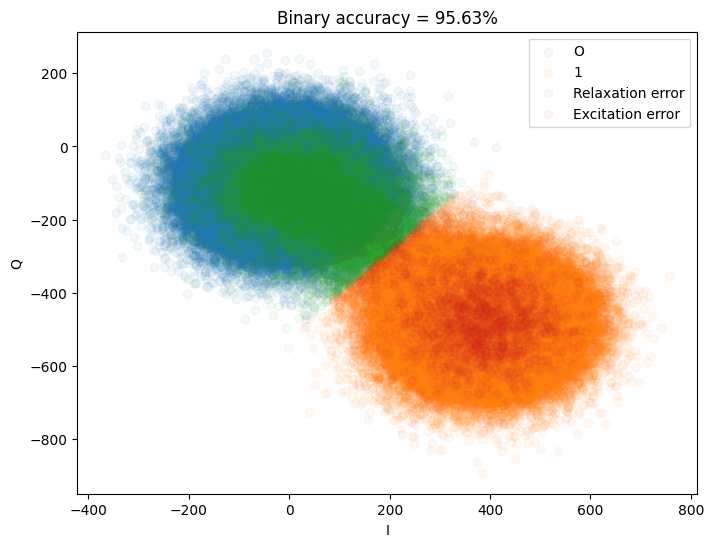

In [6]:
def split_and_time_average(X):
    # X: [N_SAMPLES, TIMESERIES_LENGTH]

    # Split into I, Q
    I_idx = [i for i in range(X.shape[1]) if i%2==0]
    Q_idx = [i for i in range(X.shape[1]) if i%2==1]
    
    X_I = X[:, I_idx]
    X_Q = X[:, Q_idx]

    # Average over time-axis
    X_I_mean = np.mean(X_I, axis=1)
    X_Q_mean = np.mean(X_Q, axis=1)
    
    return X_I_mean, X_Q_mean

def plot_threshold_fit(X, y_pred):
    X_I, X_Q = split_and_time_average(X)
    fig, ax = plt.subplots(1, figsize=(8,6))

    ax.scatter(X_I[y_pred==0], X_Q[y_pred==0], label = "O", alpha=0.05)
    ax.scatter(X_I[y_pred==1], X_Q[y_pred==1], label = "1", alpha=0.05)
    ax.scatter(X_I[y_pred==2], X_Q[y_pred==2], label = "Relaxation error", alpha=0.05)
    ax.scatter(X_I[y_pred==3], X_Q[y_pred==3], label = "Excitation error", alpha=0.05)
    ax.set_xlabel("I")
    ax.set_ylabel("Q")
    ax.legend()
    return fig, ax

fig, ax = plot_threshold_fit(X_val, y_val_prime)
ax.set_title(f"Binary accuracy = {(100*accuracy_score(y_val, y_val_threshpred)):.2f}%")
fig.show()

That'll do

## 3. Rebalance training data

Naive implementation: crop first three groups to twice size of the smallest class (in this case, excitation errors with 5298 samples), and duplicate the smallest class so there are two instances of each sample

In [7]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train_prime.shape: {y_train_prime.shape}")

N_KEEP = 4*sum(y_train_prime==3)
GLOBAL_CONFIG.update({"N_KEEP": int(N_KEEP)})

# Split into 4 classes, keep only n_keep of each class
X_tp_0 = X_train[y_train_prime==0,:][:N_KEEP,:]
y_tp_0 = y_train_prime[y_train_prime==0][:N_KEEP]

X_tp_1 = X_train[y_train_prime==1,:][:N_KEEP,:]
y_tp_1 = y_train_prime[y_train_prime==1][:N_KEEP]

X_tp_2 = X_train[y_train_prime==2,:][:N_KEEP,:]
y_tp_2 = y_train_prime[y_train_prime==2][:N_KEEP]

X_tp_3 = np.concatenate((X_train[y_train_prime==3,:],X_train[y_train_prime==3,:]), axis=0)# [:N_KEEP,:]
y_tp_3 = np.concatenate((y_train_prime[y_train_prime==3],y_train_prime[y_train_prime==3]), axis=0)# [:N_KEEP]

# Recombine
X_train = np.concatenate((X_tp_0, X_tp_1, X_tp_2, X_tp_3), axis=0)
y_train_prime = np.concatenate((y_tp_0, y_tp_1, y_tp_2, y_tp_3), axis=0)

# Shuffle
train_prime_shuffler = np.random.permutation(range(y_train_prime.shape[0]))
X_train = X_train[train_prime_shuffler,:]
y_train_prime = y_train_prime[train_prime_shuffler]

print(f"\nX_train.shape: {X_train.shape}")
print(f"y_train_prime.shape: {y_train_prime.shape}")


X_train.shape: (636300, 1540)
y_train_prime.shape: (636300,)

X_train.shape: (70700, 1540)
y_train_prime.shape: (70700,)


## 4. Crop X data to transition-window

The transitions have usually finished happening before clock-cycle #300 (see "Neural network vs. thresholding, K-fold cross-validation.ipynb", section #7).

In [8]:
def crop(X, start, end):
    # Split into I and Q
    idx_I = np.array([i for i in range(X.shape[1]) if i%2==0])
    idx_Q = np.array([i for i in range(X.shape[1]) if i%2==1])
    X_I = X[:, idx_I]
    X_Q = X[:, idx_Q]

    # Crop to desired window
    X_I = X_I[:, start:end]
    X_Q = X_Q[:, start:end]

    # Recombine
    X = np.zeros(shape = (X_I.shape[0], X_I.shape[1], 2))
    X[:, :, 0] = X_I
    X[:, :, 1] = X_Q
    X = np.reshape(X, newshape = (X_I.shape[0], 2*X_I.shape[1]))

    # Below is to test logic
    # X_I_extract = X[:, [i for i in range(X.shape[1]) if i%2==0]]
    # print(X_I.shape[0]*X_I.shape[1])
    # print(sum(sum(X_I==X_I_extract)))
    return X

if (TRANSITION_WINDOW_START, TRANSITION_WINDOW_END) != (START_WINDOW, END_WINDOW):
    print("Cropping X-data to transition-window...")
    X_train = crop(X_train, TRANSITION_WINDOW_START, TRANSITION_WINDOW_END)
    X_val = crop(X_val, TRANSITION_WINDOW_START, TRANSITION_WINDOW_END)
    X_test = crop(X_test, TRANSITION_WINDOW_START, TRANSITION_WINDOW_END)

Cropping X-data to transition-window...


## 5. One-hot encode y data for neural network

In [9]:
y_train_prime_oh = one_hot_encode(y_train_prime)
y_val_prime_oh = one_hot_encode(y_val_prime)
y_tv_prime_oh = np.concatenate((y_train_prime_oh, y_val_prime_oh), axis=0)
y_test_prime_oh = one_hot_encode(y_test_prime)

print(f"y_train_prime_oh.shape: {y_train_prime_oh.shape}")
print(f"y_val_prime_oh.shape: {y_val_prime_oh.shape}")
print(f"y_tv_prime_oh.shape: {y_tv_prime_oh.shape}")

y_train_prime_oh.shape: (70700, 4)
y_val_prime_oh.shape: (272700, 4)
y_tv_prime_oh.shape: (343400, 4)


## 6. Train Neural network

Construct NN

In [10]:
# Optimal hyperparameters per J
CHECKPOINT_FILENAME = os.path.join(SAVE_DIR, "qmodel.h5")
INPUT_SHAPE = (len(X_train[0]),)
GLOBAL_CONFIG.update({"CHECKPOINT_FILENAME": CHECKPOINT_FILENAME, "INPUT_SHAPE": INPUT_SHAPE})

# model = Sequential()
# model.add(Dense(4, input_shape=INPUT_SHAPE, name='fc1'))# , kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
# model.add(ReLU())
# model.add(Dense(4, input_shape=(20,), name='fc2'))#, kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
# model.add(Softmax())

model = Sequential()
model.add(Dense(700, input_shape=INPUT_SHAPE, name='fc1'))#, kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dense(400, input_shape=(700,), name='fc2'))#, kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dense(100, input_shape=(400,), name='fc3'))#, kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dense(10, input_shape=(100,), name='fc4'))#, kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
model.add(ReLU())
model.add(BatchNormalization())
model.add(Dense(4, input_shape=(10,), name='fc5'))#, kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
model.add(Softmax())

# adding pruning 
PRUNE = False
if PRUNE:
    pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=200, end_step=1000)}
    model = prune.prune_low_magnitude(model, **pruning_params)

MODEL_SUMMARY_F = os.path.join(SAVE_DIR, "model_summary.txt")
def myprint(s):
    with open(MODEL_SUMMARY_F,'a') as f:
        print(s, file=f)

model.summary(print_fn = myprint)
GLOBAL_CONFIG.update({"MODEL_SUMMARY_F": MODEL_SUMMARY_F})

2024-05-31 18:11:54.240108: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-05-31 18:11:54.240138: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-31 18:11:54.240163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator3.fnal.gov): /proc/driver/nvidia/version does not exist
2024-05-31 18:11:54.240399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
X_tt = X_train[:10, :]
y_tt = model(X_tt)
print(f"X_tt.shape: {X_tt.shape}")
print(f"y_tt.shape: {y_tt.shape}")

print(model.summary())

X_tt.shape: (10, 1000)
y_tt.shape: (10, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 700)               700700    
                                                                 
 re_lu (ReLU)                (None, 700)               0         
                                                                 
 batch_normalization (BatchN  (None, 700)              2800      
 ormalization)                                                   
                                                                 
 fc2 (Dense)                 (None, 400)               280400    
                                                                 
 re_lu_1 (ReLU)              (None, 400)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 400)              1600      
 hNormalizati

Train it

In [12]:
callbacks = [
    ModelCheckpoint(
    CHECKPOINT_FILENAME,
    monitor="val_loss",
    save_best_only=True,  # Note: J's version doesn't comment this out. Here it's necessary because there is no validation set
    save_weights_only=False,
    save_freq="epoch",
    ),
    ReduceLROnPlateau(patience=60, min_delta=1**-6), # Note: J's version doesn't comment this out. Here it's necessary because there is no validation set
    pruning_callbacks.UpdatePruningStep(),
]
    
opt = Adam(learning_rate=INIT_LEARNING_RATE)
model.compile(
    optimizer=opt, 
    # loss=tf.keras.losses.BinaryCrossentropy(),
    loss=CategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy']
)

print(f"X_train.shape: {X_train.shape}")
history = model.fit(
    X_train, 
    y_train_prime_oh, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    shuffle=True, 
    callbacks=callbacks,
    verbose = 1
)


X_train.shape: (70700, 1000)
Epoch 1/50
4/4 [==============================] - 2s 256ms/step - loss: 1.3139 - accuracy: 0.4356 - val_loss: 27.4510 - val_accuracy: 0.3620 - lr: 0.0100
Epoch 2/50
4/4 [==============================] - 1s 146ms/step - loss: 0.8128 - accuracy: 0.6490 - val_loss: 49.1890 - val_accuracy: 0.3465 - lr: 0.0100
Epoch 3/50
4/4 [==============================] - 1s 135ms/step - loss: 0.7378 - accuracy: 0.6669 - val_loss: 45.2389 - val_accuracy: 0.3473 - lr: 0.0100
Epoch 4/50
4/4 [==============================] - 1s 139ms/step - loss: 0.6961 - accuracy: 0.6751 - val_loss: 33.1024 - val_accuracy: 0.3498 - lr: 0.0100
Epoch 5/50
4/4 [==============================] - 1s 146ms/step - loss: 0.6632 - accuracy: 0.6863 - val_loss: 24.7025 - val_accuracy: 0.3580 - lr: 0.0100
Epoch 6/50
4/4 [==============================] - 1s 142ms/step - loss: 0.6301 - accuracy: 0.7018 - val_loss: 17.7864 - val_accuracy: 0.3664 - lr: 0.0100
Epoch 7/50
4/4 [==============================]

Strip pruning and save

In [13]:
if PRUNE:
    model = strip_pruning(model)
    model.save(CHECKPOINT_FILENAME)

history_file = CHECKPOINT_FILENAME.replace(".h5", "-history.pkl")
with open(history_file, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print(f'Saving history to: {history_file}')
print(f'Saved checkpoint to: {CHECKPOINT_FILENAME}')

Saving history to: /data/aelabd/ml-quantum-readout/notebooks/transition_errors/66/qmodel-history.pkl
Saved checkpoint to: /data/aelabd/ml-quantum-readout/notebooks/transition_errors/66/qmodel.h5


## 7. Check performance on validation data

In [14]:
y_val_nnpred = model.predict(X_val)

8522/8522 [==============================] - 22s 3ms/step


In [15]:
creport = classification_report(y_val_prime, np.argmax(y_val_nnpred, axis=1), target_names = ["0", "1", "Relaxation error", "Excitation error"])
cmat = confusion_matrix(y_val_prime, np.argmax(y_val_nnpred, axis=1))

print("Classification report:")
print(creport)
np.save(os.path.join(SAVE_DIR, "classification_report_validation_set.npy"), creport)

print("\n\nConfusion matrix:")
print(cmat)
np.save(os.path.join(SAVE_DIR, "confusion_matrix_validation_set.npy"), cmat)

Classification report:
                  precision    recall  f1-score   support

               0       0.96      0.77      0.85    134229
               1       0.98      0.75      0.85    126553
Relaxation error       0.10      0.43      0.16      9672
Excitation error       0.02      0.21      0.03      2246

        accuracy                           0.74    272700
       macro avg       0.51      0.54      0.47    272700
    weighted avg       0.93      0.74      0.82    272700



Confusion matrix:
[[102697    217  30677    638]
 [   208  95183   6015  25147]
 [  4522    669   4125    356]
 [    58   1533    178    477]]


Check performance on rebalanced validation set

In [16]:
n_val_keep = sum(y_val_prime==3)

X_val_k0 = X_val[y_val_prime==0][:n_val_keep]
y_val_k0 = y_val_prime[y_val_prime==0][:n_val_keep]

X_val_k1 = X_val[y_val_prime==1][:n_val_keep]
y_val_k1 = y_val_prime[y_val_prime==1][:n_val_keep]

X_val_k2 = X_val[y_val_prime==2][:n_val_keep]
y_val_k2 = y_val_prime[y_val_prime==2][:n_val_keep]

X_val_k3 = X_val[y_val_prime==3]
y_val_k3 = y_val_prime[y_val_prime==3]

X_val_k = np.concatenate((X_val_k0, X_val_k1, X_val_k2, X_val_k3), axis=0)
y_val_prime_k = np.concatenate((y_val_k0, y_val_k1, y_val_k2, y_val_k3), axis=0)

y_val_nnpred_k = model.predict(X_val_k)

281/281 [==============================] - 1s 2ms/step


In [17]:
creport_k = classification_report(y_val_prime_k, np.argmax(y_val_nnpred_k, axis=1), target_names = ["0", "1", "Relaxation error", "Excitation error"])
cmat_k = confusion_matrix(y_val_prime_k, np.argmax(y_val_nnpred_k, axis=1))

print("Classification report:")
print(creport_k)

print("\n\nConfusion matrix:")
print(cmat_k)

Classification report:
                  precision    recall  f1-score   support

               0       0.60      0.77      0.67      2246
               1       0.50      0.76      0.61      2246
Relaxation error       0.54      0.41      0.46      2246
Excitation error       0.47      0.21      0.29      2246

        accuracy                           0.54      8984
       macro avg       0.53      0.54      0.51      8984
    weighted avg       0.53      0.54      0.51      8984



Confusion matrix:
[[1720    2  510   14]
 [   4 1708   97  437]
 [1097  149  913   87]
 [  58 1533  178  477]]


## 8. Visualization

In [18]:
def split_and_sample_average(X):
    # X: [N_SAMPLES, TIMESERIES_LENGTH]

    # Split into I, Q
    I_idx = [i for i in range(X.shape[1]) if i%2==0]
    Q_idx = [i for i in range(X.shape[1]) if i%2==1]
    
    X_I = X[:, I_idx]
    X_Q = X[:, Q_idx]

    # Average over sample-axis
    X_I_mean = np.mean(X_I, axis=0)
    X_Q_mean = np.mean(X_Q, axis=0)
    
    return X_I_mean, X_Q_mean

In [19]:
def plot_pred(X, y, y_pred, alpha=0.1):

    X_I, X_Q = split_and_time_average(X)

    ################### Plot ###########################
    fig, (ax_0, ax_1, ax_2, ax_3) = plt.subplots(4, 1, figsize = (8, 28))
    ax_0.scatter(X_I[y==0], X_Q[y==0], label = "Truth labels (per thresholding)", alpha = 0.02)
    ax_0.scatter(X_I[y_pred==0], X_Q[y_pred==0], label = "Model predictions", alpha = 0.02)
    ax_0.set_xlabel("I")
    ax_0.set_ylabel("Q")
    ax_0.set_title("|0> states")
    ax_0.legend(bbox_to_anchor = [1,1])
    ax_0.set_xlim([-700, 1000])
    ax_0.set_ylim([-1100, 500])
    ax_0.legend(bbox_to_anchor=[1,1])

    ax_1.scatter(X_I[y==1], X_Q[y==1], label = "Truth labels (per thresholding)", alpha = 0.02)
    ax_1.scatter(X_I[y_pred==1], X_Q[y_pred==1], label = "Model predictions", alpha = 0.02)
    ax_1.set_xlabel("I")
    ax_1.set_ylabel("Q")
    ax_1.set_title("|1> states")
    ax_1.legend(bbox_to_anchor = [1,1])
    ax_1.set_xlim([-700, 1000])
    ax_1.set_ylim([-1100, 500])
    ax_1.legend(bbox_to_anchor=[1,1])

    ax_2.scatter(X_I[y==2], X_Q[y==2], label = "Truth labels (per thresholding)", alpha = 0.02)
    ax_2.scatter(X_I[y_pred==2], X_Q[y_pred==2], label = "Model predictions", alpha = 0.02)
    ax_2.set_xlabel("I")
    ax_2.set_ylabel("Q")
    ax_2.set_title("Relaxation errors")
    ax_2.legend(bbox_to_anchor = [1,1])
    ax_2.set_xlim([-700, 1000])
    ax_2.set_ylim([-1100, 500])
    ax_2.legend(bbox_to_anchor=[1,1])

    ax_3.scatter(X_I[y==3], X_Q[y==3], label = "Truth labels (per thresholding)", alpha = 0.02)
    ax_3.scatter(X_I[y_pred==3], X_Q[y_pred==3], label = "Model predictions", alpha = 0.02)
    ax_3.set_xlabel("I")
    ax_3.set_ylabel("Q")
    ax_3.set_title("Excitation errors")
    ax_3.legend(bbox_to_anchor = [1,1])
    ax_3.set_xlim([-700, 1000])
    ax_3.set_ylim([-1100, 500])
    ax_3.legend(bbox_to_anchor=[1,1])
    
    return fig, (ax_0, ax_1, ax_2, ax_3)

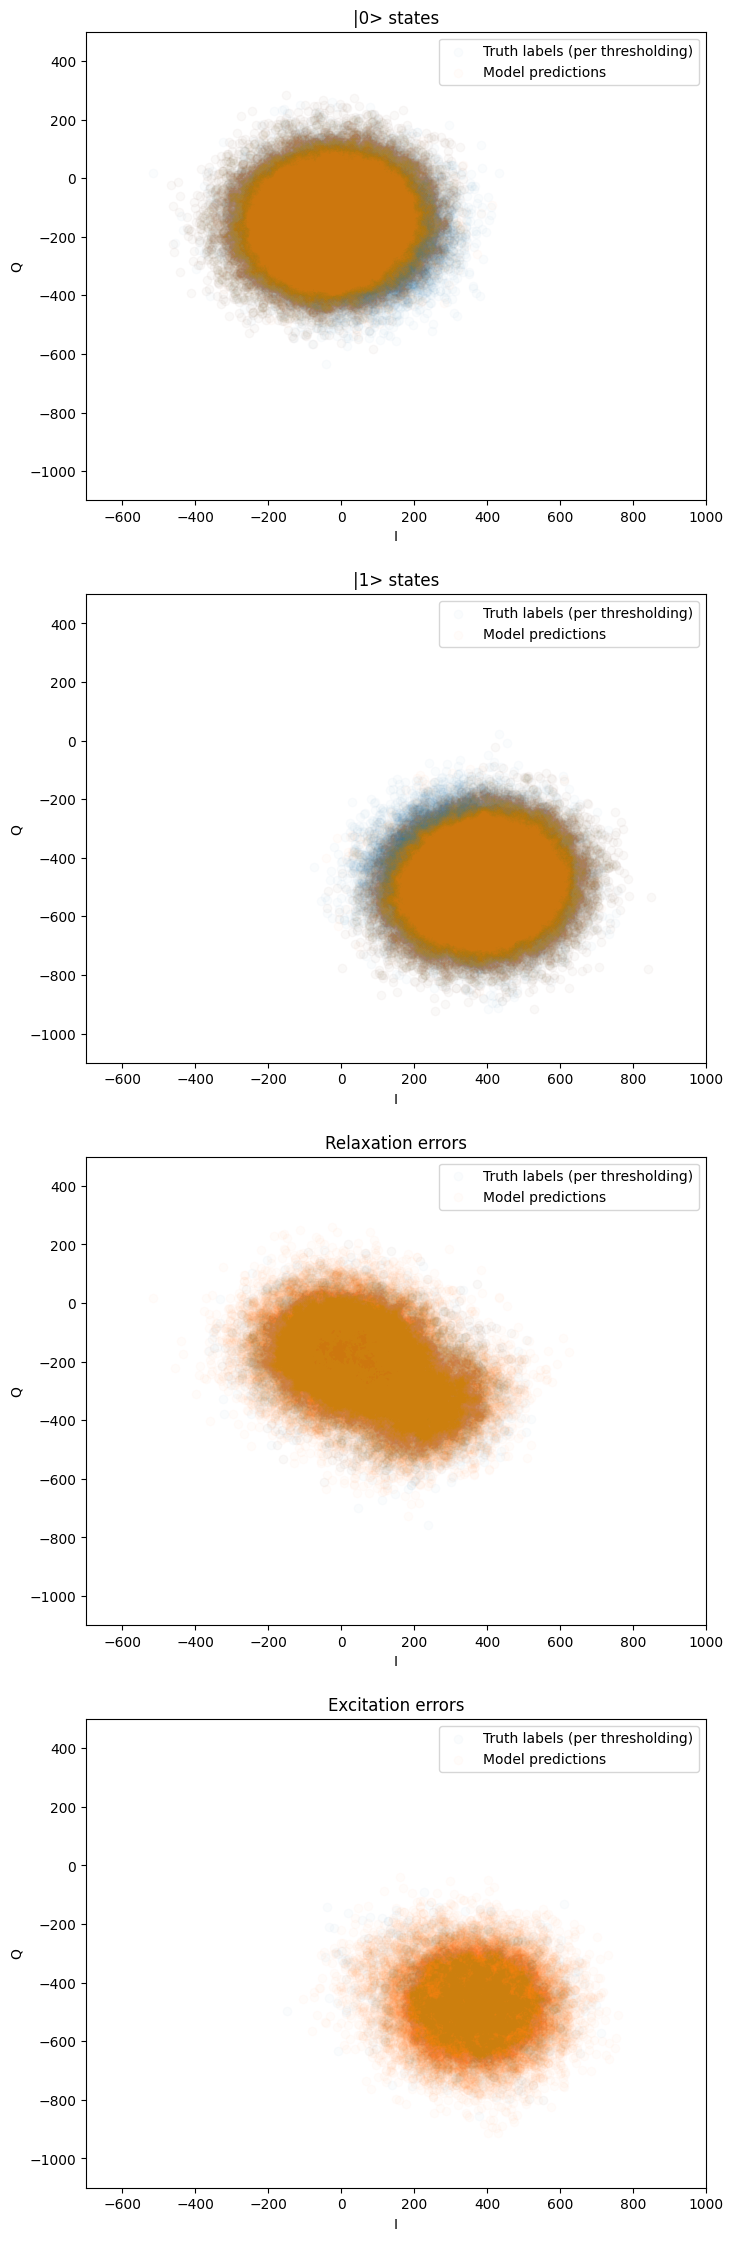

In [20]:
fig, (ax_0, ax_1, ax_2, ax_3) = plot_pred(X_val, y_val_prime, np.argmax(y_val_nnpred, axis=1))
fig.savefig(os.path.join(SAVE_DIR, "predictions_validation_set.png"), bbox_inches="tight")
fig.show()

In [21]:
def plot_traces(X, y):

    # True positives
    idx_0 = np.where(y==0)[0]
    X_0 = X[idx_0]
    X_0_I, X_0_Q = split_and_sample_average(X_0)
    

    # False negatives
    idx_1 = np.where(y==1)[0]
    X_1 = X[idx_1]
    X_1_I, X_1_Q = split_and_sample_average(X_1)

    # True negatives
    idx_2 = np.where(y==2)[0]
    X_2 = X[idx_2]
    X_2_I, X_2_Q = split_and_sample_average(X_2)
    
    # False positives
    idx_3 = np.where(y==3)[0]
    X_3 = X[idx_3]
    X_3_I, X_3_Q = split_and_sample_average(X_3)


    ################### Plot ###########################
    fig, (ax_I, ax_Q) = plt.subplots(2,1, figsize = (12, 8))
    ax_I.plot(range(X_0_I.shape[0]), X_0_I, label = "|0> states")
    ax_I.plot(range(X_1_I.shape[0]), X_1_I, label = "|1> states")
    ax_I.plot(range(X_2_I.shape[0]), X_2_I, label = "Relaxation errors")
    ax_I.plot(range(X_3_I.shape[0]), X_3_I, label = "Excitation errors")
    ax_I.set_xlabel("Clock cycle (~3ns)")
    ax_I.set_ylabel("I")
    ax_I.legend(bbox_to_anchor = (1,1))
    
    ax_Q.plot(range(X_0_Q.shape[0]), X_0_Q, label = "|0> states")
    ax_Q.plot(range(X_1_Q.shape[0]), X_1_Q, label = "|1> states")
    ax_Q.plot(range(X_2_Q.shape[0]), X_2_Q, label = "Relaxation errors")
    ax_Q.plot(range(X_3_Q.shape[0]), X_3_Q, label = "Excitation errors")
    ax_Q.set_xlabel("Clock cycle (~3ns)")
    ax_Q.set_ylabel("Q")
    ax_Q.legend(bbox_to_anchor = (1,1))
    
    return fig, (ax_I, ax_Q)

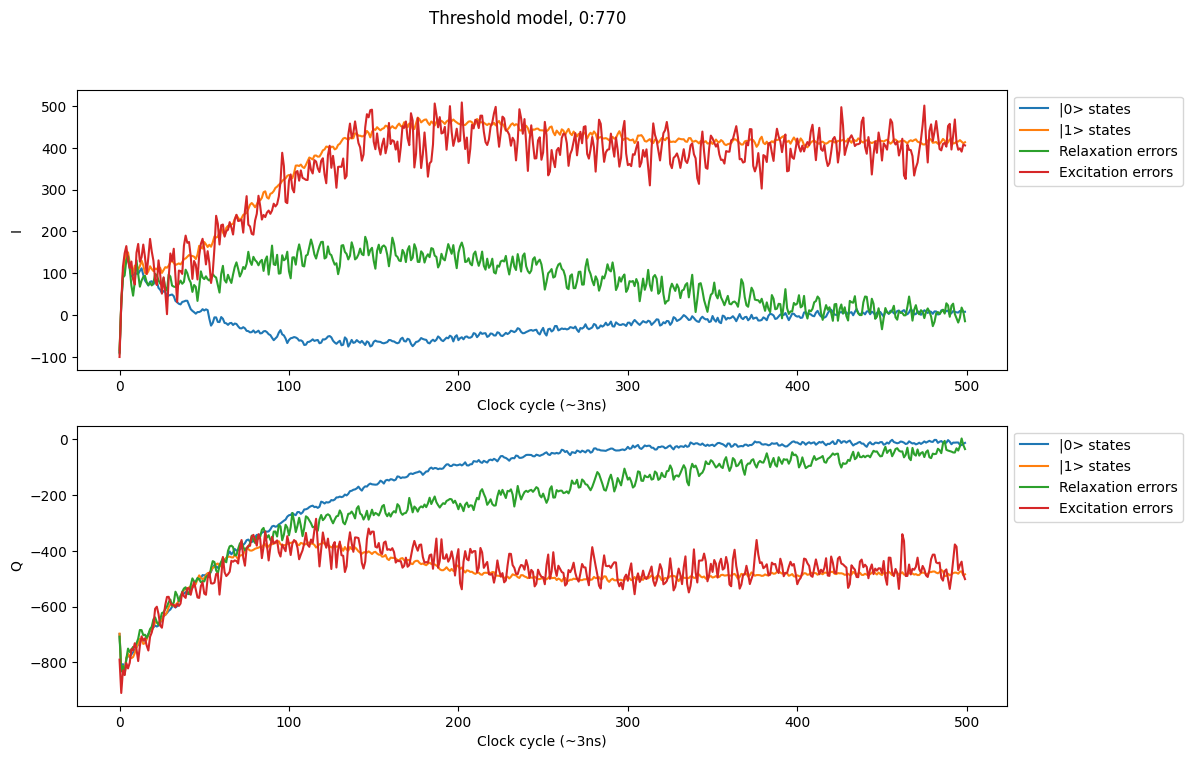

In [22]:
fig_thresh_trace, (ax_I_thresh_trace, ax_Q_thresh_trace) = plot_traces(X_val, y_val_prime)
fig_thresh_trace.suptitle(f"Threshold model, {START_WINDOW}:{END_WINDOW}")
fig_thresh_trace.savefig(os.path.join(SAVE_DIR,"thresh_traces.png"), bbox_inches="tight")
fig_thresh_trace.show()

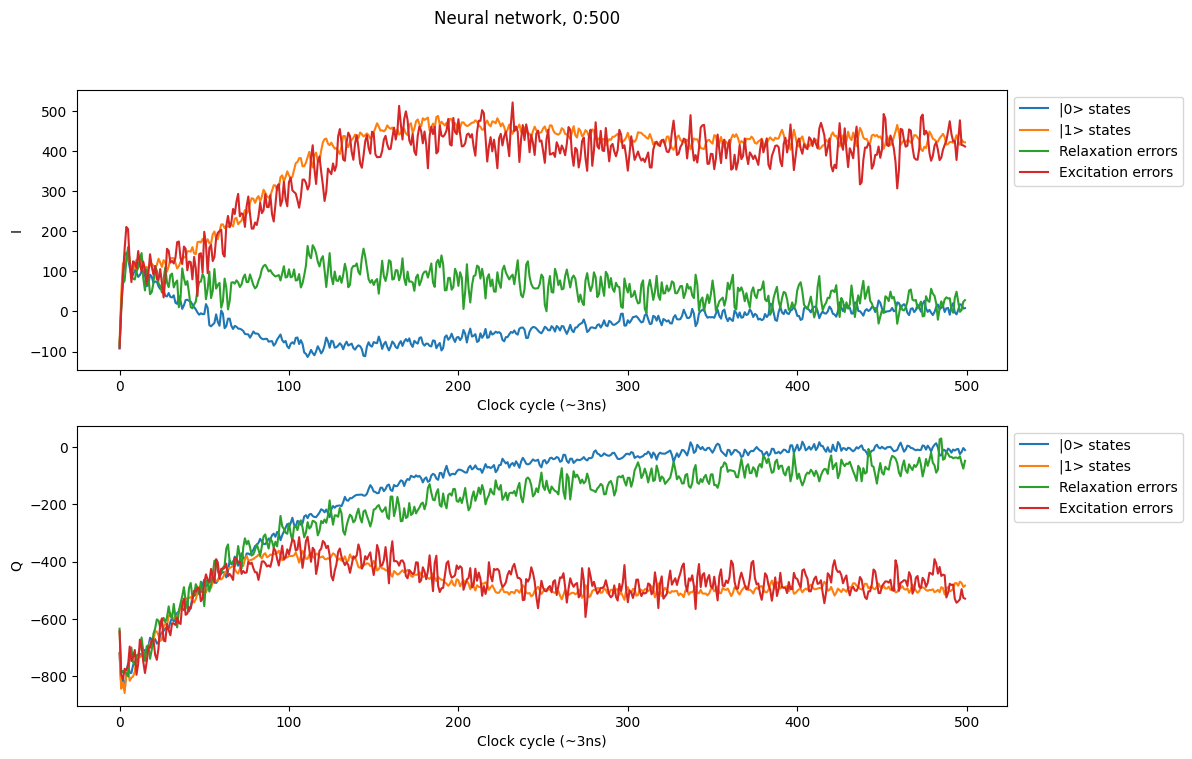

In [23]:
fig_NN_trace, (ax_I_NN_trace, ax_Q_NN_trace) = plot_traces(X_val, np.argmax(y_val_nnpred, axis = 1))
fig_NN_trace.suptitle(f"Neural network, {TRANSITION_WINDOW_START}:{TRANSITION_WINDOW_END}")
fig_NN_trace.savefig(os.path.join(SAVE_DIR, "NN_traces.png"), bbox_inches="tight")
fig_NN_trace.show()

## 9. Save config file

In [24]:
GLOBAL_CONFIG.update(
    {"thresh_mod.threshold": str(thresh_mod.threshold), 
     "thresh_mod.theta": str(thresh_mod.theta), 
     "THETA_MUL": THETA_MUL, 
     "THRESH_MUL": THRESH_MUL,
    "PRUNE": PRUNE})
for k,v in GLOBAL_CONFIG.items():
    print(f"{k}: {v}")

VALIDATION_SPLIT: 0.3
NP_SEED: 0
START_WINDOW: 0
END_WINDOW: 770
DATA_DIR: ../data/data_0_resplit
TRANSITION_WINDOW_START: 0
TRANSITION_WINDOW_END: 500
INIT_LEARNING_RATE: 0.01
BATCH_SIZE: 12800
EPOCHS: 50
N_KEEP: 20200
CHECKPOINT_FILENAME: /data/aelabd/ml-quantum-readout/notebooks/transition_errors/66/qmodel.h5
INPUT_SHAPE: (1000,)
MODEL_SUMMARY_F: /data/aelabd/ml-quantum-readout/notebooks/transition_errors/66/model_summary.txt
thresh_mod.threshold: 335.1802657457768
thresh_mod.theta: 0.711410514282019
THETA_MUL: 0.94
THRESH_MUL: 1.2
PRUNE: False


In [25]:
with open(os.path.join(SAVE_DIR, "config.yml"), "w") as f:
    yaml.dump(GLOBAL_CONFIG, f)

In [26]:
SAVE_DIR

'/data/aelabd/ml-quantum-readout/notebooks/transition_errors/66'